In [163]:
def modelCircle(b, c, d):
  temp = c[0]**2 + c[1]**2
  bc = (b[0]**2 + b[1]**2 - temp) / 2
  cd = (temp - d[0]**2 - d[1]**2) / 2
  det = (b[0] - c[0]) * (c[1] - d[1]) - (c[0] - d[0]) * (b[1] - c[1])

  if abs(det) < 1.0e-10:
    return None

  # Center of circle
  cx = (bc*(c[1] - d[1]) - cd*(b[1] - c[1])) / det
  cy = ((b[0] - c[0]) * cd - (c[0] - d[0]) * bc) / det

  radius = ((cx - b[0])**2 + (cy - b[1])**2)**.5

  return cx,cy,radius

def shrtDis(p,x,y,r):
    import numpy as np
    re= np.array(abs(((p[:,0]-x)**2+(p[:,1]-y)**2)**0.5-r))
    return re

In [164]:
x,y,r=modelCircle([-3,-2],[2,3],[1,0])
shrtDis([-2,0],x,y,r)

TypeError: list indices must be integers or slices, not tuple

In [355]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
# np . random. seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r /16
t = np . random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b =-1, 2
x = np.linspace(-12, 12 , half_n )
y = m*x + b + s*np . random. randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )








#result = np.where(PO<1)


0.49608627754676315 45
0.4696007161636422 47
0 0


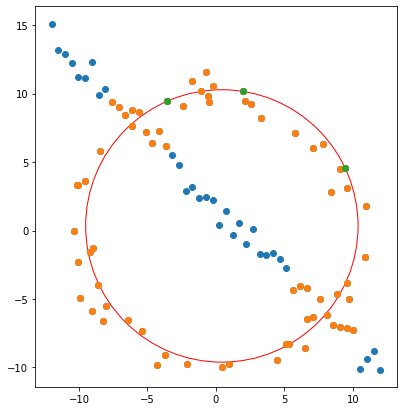

In [360]:
best=np.Infinity
v,m,R,ranL=0,0,0,[]

for i in range(40):
    #L=np.random.random_integers(0,99,size=3)
    L=np.random.choice(100, size=3, replace=False)
    
  
    x,y,r=modelCircle(X[L[0]],X[L[1]],X[L[2]])
    PO=shrtDis(X,x,y,r)
    if r>15:
        continue
    inliares=X[PO<1]
    if inliares.size>80:
        
        me=shrtDis(inliares,x,y,r)
        mean = sum(me/me.size)
        if mean < best:
            print(mean,me.size)
            best=mean
            ranL=L
            

x,y,r=modelCircle(X[ranL[0]],X[ranL[1]],X[ranL[2]])
PO=shrtDis(X,x,y,r)
bestInlier=X[PO<3]
fig,ax=plt.subplots(figsize=(7,7))

c=plt.Circle((x,y),r,fill=False)
c.set_color("r")
ax.set_aspect( 1 )
ax.add_artist( c )
ax.scatter(X[:,0],X[:,1])
ax.scatter(bestInlier[:,0],bestInlier[:,1])
Y=np.vstack((X[ranL[0]],X[ranL[1]],X[ranL[2]]))
ax.scatter(Y[:,0],Y[:,1])
print(v,m)



In [312]:
print(R)

14.139035615884929


In [334]:
Y=np.vstack((X[ranL[0]],X[ranL[1]],X[ranL[2]]))
Y


array([[ 2.58397336, 10.16207325],
       [-3.88802805,  9.79229891],
       [ 9.9242008 , -0.24491535]])